# Utilising Tree SHAP for Exploratory Data Analysis  
This blogpost is an experiment into using Scott Lundberg's [TreeExplainer](https://github.com/slundberg/shap) (an implementation of Tree SHAP) alongside XGBoost to see what we can learn from a dataset.

The data I am using comes from the UCIML [Student Alcohol Consumption](https://www.kaggle.com/uciml/student-alcohol-consumption) dataset. The two .csvs (split by whether the students study Portuguese or Mathematics) contain survey answers to a wide variety of questions concerning: alcohol consumption, social life, health etc for individual students. Paired with these self-reported answers we also have the total number of absences, the amount of prior class failures and the grade attained in three classes, G1, G2, G3.

Despite the grades referring to different classes for the two cohorts (Mathematics and Portuguese) I chose to combine them. 

In [4]:
!pip install shap

In [0]:
import numpy as np 
np.random.seed(0)
import pandas as pd 
import shap
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pylab as pl
import matplotlib.pyplot as plt

In [6]:
math_data = pd.read_csv("student-mat.csv")
print(math_data.head())
port_data = pd.read_csv("student-por.csv")
print(port_data.head())

  school sex  age address famsize Pstatus  ...  Walc  health absences  G1  G2  G3
0     GP   F   18       U     GT3       A  ...     1       3        6   5   6   6
1     GP   F   17       U     GT3       T  ...     1       3        4   5   5   6
2     GP   F   15       U     LE3       T  ...     3       3       10   7   8  10
3     GP   F   15       U     GT3       T  ...     1       5        2  15  14  15
4     GP   F   16       U     GT3       T  ...     2       5        4   6  10  10

[5 rows x 33 columns]
  school sex  age address famsize Pstatus  ...  Walc  health absences  G1  G2  G3
0     GP   F   18       U     GT3       A  ...     1       3        4   0  11  11
1     GP   F   17       U     GT3       T  ...     1       3        2   9  11  11
2     GP   F   15       U     LE3       T  ...     3       3        6  12  13  12
3     GP   F   15       U     GT3       T  ...     1       5        0  14  14  14
4     GP   F   16       U     GT3       T  ...     2       5        0  11  

## Merging, Cleaning, & Tidying the Data
Here we combine both data sets and replace `['yes', 'no']` columns with `[1, 0]`. Then we make use of the pandas get_dummies() function, which one-hot encodes our other non-numeric features.

In [7]:
all_data = pd.merge(math_data, port_data, how='outer')
tidy_data = all_data.replace(['yes', 'no'], [1, 0])

#one-hot encode the dataframe for xgboost
tidy_data = pd.get_dummies(tidy_data)
tidy_data.head()

,age,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
0,18,4,4,2,2,0,1,0,0,0,1,1,0,0,4,3,4,1,1,3,6,5,6,6,1,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0
1,17,1,1,1,2,0,0,1,0,0,0,1,1,0,5,3,3,1,1,3,4,5,5,6,1,0,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
2,15,1,1,1,2,3,1,0,1,0,1,1,1,0,4,3,2,2,3,3,10,7,8,10,1,0,1,0,0,1,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
3,15,4,2,1,3,0,0,1,1,1,1,1,1,1,3,2,2,1,1,5,2,15,14,15,1,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0
4,16,3,3,1,2,0,0,1,1,0,1,1,0,0,4,3,2,1,2,5,4,6,10,10,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0


## **Experiment 1**: Building an XGBoost model to predict G3 
Here we split the train/test set and build DMatrices to feed our model. 

In [8]:
#Build the xgboost matrices
train, test = train_test_split(tidy_data, test_size=0.2, random_state=1)

X_train = train.drop(['G3'], axis=1)
y_train = train['G3']

X_test = test.drop(['G3'], axis=1)
y_test = test['G3']

xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

Series.base is deprecated and will be removed in a future version
Series.base is deprecated and will be removed in a future version


In [9]:
# Train
params = {
    "eta": 0.002,
    "max_depth": 3,
    "objective": "reg:squarederror",
    "eval_metric": "mae",
    "subsample": 0.5,
    "verbose": 2
}
model_train = xgboost.train(params, xgb_train, 2000, evals = [(xgb_test, "test")], verbose_eval=100)

[0]	test-mae:10.8332
[100]	test-mae:8.95158
[200]	test-mae:7.4079
[300]	test-mae:6.14129
[400]	test-mae:5.1035
[500]	test-mae:4.25053
[600]	test-mae:3.54838
[700]	test-mae:2.97323
[800]	test-mae:2.50993
[900]	test-mae:2.12958
[1000]	test-mae:1.82349
[1100]	test-mae:1.58184
[1200]	test-mae:1.39951
[1300]	test-mae:1.2592
[1400]	test-mae:1.14735
[1500]	test-mae:1.05777
[1600]	test-mae:0.993429
[1700]	test-mae:0.946351
[1800]	test-mae:0.914696
[1900]	test-mae:0.894999
[1999]	test-mae:0.883885


That went well! Mean absolute error on the test set is 0.88, meaning when we predict grades, on average we're off by +/-0.88 points.    
Let's use TreeExplainer to interpret our model.

In [10]:
shap_values = shap.TreeExplainer(model_train).shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


### Summary Plot
The chart below shows us to what degree (and how) each of our features affects each prediction. I made the mistake of leaving G2 and G1 in the training set, which are both highly correlated with G3 so our model overly relies on them. The SHAP value (x-axis) directly shows how much each feature 'contributes' to our prediction.

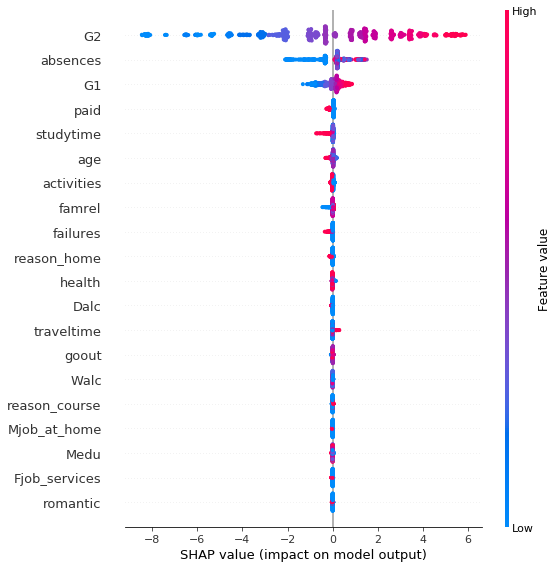

In [11]:
shap.summary_plot(shap_values, X_train)

## **Experiment 1 part 2**: Building a model to predict *TOTAL* Grade

In [0]:
tidy_data["grade"] = tidy_data["G1"] + tidy_data["G2"] + tidy_data["G3"]

In [13]:
#Build the xgboost matrices
train, test = train_test_split(tidy_data, test_size=0.2, random_state=1)

X_train = train.drop(['G1', 'G2', 'G3', 'grade'], axis=1)
y_train = train['grade']

X_test = test.drop(['G1', 'G2', 'G3', 'grade'], axis=1)
y_test = test['grade']

xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

Series.base is deprecated and will be removed in a future version
Series.base is deprecated and will be removed in a future version


In [14]:
model_train = xgboost.train(params, xgb_train, 2000, evals = [(xgb_test, "test")], verbose_eval=100)

[0]	test-mae:33.0317
[100]	test-mae:27.055
[200]	test-mae:22.2298
[300]	test-mae:18.3214
[400]	test-mae:15.2196
[500]	test-mae:12.7611
[600]	test-mae:10.823
[700]	test-mae:9.32992
[800]	test-mae:8.19043
[900]	test-mae:7.36914
[1000]	test-mae:6.83531
[1100]	test-mae:6.50359
[1200]	test-mae:6.28324
[1300]	test-mae:6.14044
[1400]	test-mae:6.03739
[1500]	test-mae:5.96163
[1600]	test-mae:5.90218
[1700]	test-mae:5.86302
[1800]	test-mae:5.84015
[1900]	test-mae:5.81992
[1999]	test-mae:5.80402


Our mean absolute error on the test set is worse here - but expectedly so. The maximum grade possible is 60 so our model is giving us a ~5% swing either way.

In [15]:
shap_values = shap.TreeExplainer(model_train).shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


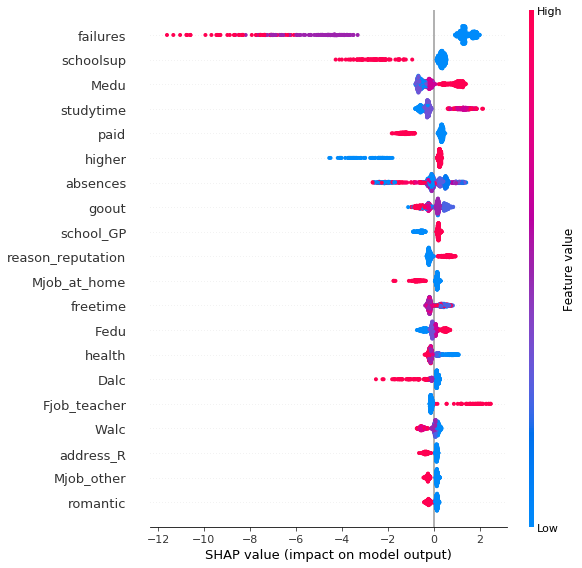

In [16]:
shap.summary_plot(shap_values, X_train)

This chart is much more interesting than the one above! Interesting things to note from this:  
* **failures**: *number of previous class failures 0, 1, 2, 3 or more* has the strongest effect on the prediction.
* **schoolsup**: *whether the school provides extra support* has an inverse relationship with shapley values. This unfortunately leads us to the poor conclusion that the school support makes students worse. It is likely that students with support do better than they would without it, but overall are still worse than the average student causing this unfortunate interaction. 
* **Medu**: *the student's Mother's education level from 0 -> 4* Here it appears that this feature is only positive when it is at maximum (4), and all other values lead to a negative impact. I would wager that this relates to the value 4 representing Higher Education which is an indicator of middle-classness.
* **Fjob_teacher**: *1 if the student's Father is a teacher*, this is an interesting one as it has some of the highest positive impact on the output. 

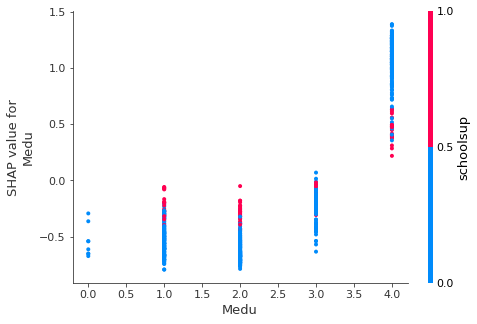

In [17]:
shap.dependence_plot("Medu", shap_values, X_train)

The dependence plot function demonstrated above selects a secondary feature that interacts the most with our primary feature. Through the colouring it allows us to investigate whether there is a relationship between our two features. Here it has selected 'schoolsup' *whether the school provides extra support* against our selection of 'Medu' *Student's Mother's educational attainment*.  

This chart shows us that when the student has extra support from the school, the absolute SHAP value we give for all values of Medu is reduced. This interaction means that the potential helpful or hindering effect that your Mother's education has on your school performance is reduced if the school steps in to help.

## **Experiment 2**: Can we build a tool to determine whether a student needs support?

We have already uncovered the unfortunate effect 'schoolsup' has on our prediction. To investigate this further I wrote a function that allows a teacher to calculate the difference in total grade prediction if a sample student is given support or not - There is a practical use case for this: it is obvious to a teacher if a student doesn't need support when they are achieving, but it would be useful to classify who would gain the most from support for more 'efficient' allocation of resources/time.

In [18]:
#Build the xgboost matrices
train, test = train_test_split(tidy_data, test_size=0.2, random_state=1)
features = ['failures', 'absences', 'studytime', 'freetime', 'schoolsup', 'traveltime', 'age', 'sex_F']

X_train = train[features]
y_train = train['grade']

X_test = test[features]
y_test = test['grade']

X_total = tidy_data[features]

xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

Series.base is deprecated and will be removed in a future version
Series.base is deprecated and will be removed in a future version


[0]	test-mae:33.0319
[100]	test-mae:27.054
[200]	test-mae:22.2326
[300]	test-mae:18.3568
[400]	test-mae:15.2591
[500]	test-mae:12.8206
[600]	test-mae:10.911
[700]	test-mae:9.45719
[800]	test-mae:8.37533
[900]	test-mae:7.61934
[1000]	test-mae:7.09328
[1100]	test-mae:6.76395
[1200]	test-mae:6.5586
[1300]	test-mae:6.40871
[1400]	test-mae:6.29853
[1500]	test-mae:6.22423
[1600]	test-mae:6.17954
[1700]	test-mae:6.14716
[1800]	test-mae:6.1301
[1900]	test-mae:6.11673
[1999]	test-mae:6.10779


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


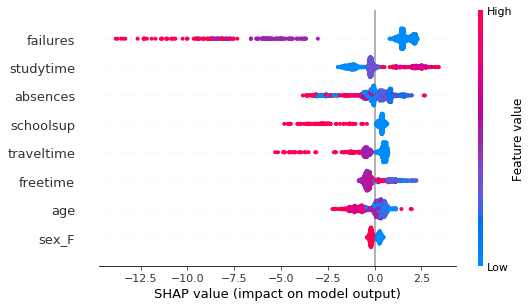

In [19]:
model_train = xgboost.train(params, xgb_train, 2000, evals = [(xgb_test, "test")], verbose_eval=100)
shap_values = shap.TreeExplainer(model_train).shap_values(X_total)
shap.summary_plot(shap_values, X_total)

I limited the features in this model to ones that a teacher would feasibly know about (or could take a guess at).  
The accuracy did not suffer a great deal as a result of this: MAE 5.8 -> 6.1

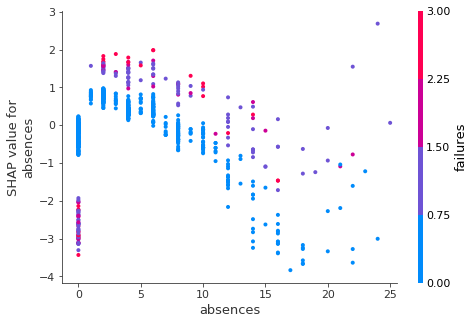

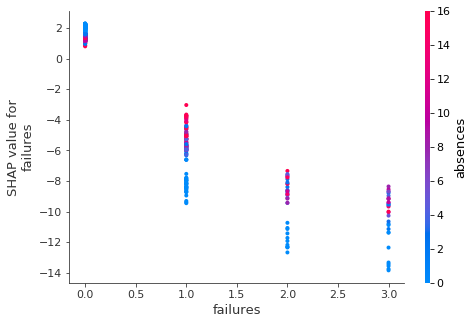

In [20]:
shap.dependence_plot("absences", shap_values, X_total, xmax="percentile(99)")
shap.dependence_plot("failures", shap_values, X_total)

Here we see a similar relationship to Medu-schoolsup from earlier. A greater number of absences causes a students output value for failures to be less negative, except when failures = 0. The novel thing here is that the first chart shows us what this looks like on a continuous feature instead of a discrete ordinal one.

In [21]:
test_student = pd.DataFrame({"failures" : [2, 2],
                             "absences" : [0, 0],
                             "studytime" : [1, 1],
                             "freetime" : [0, 0],
                             "schoolsup" : [0, 1],
                             "traveltime" : [2, 2],
                             "age" : [18, 18],
                             "sex_F" : [0, 0]})

dataMatrix = xgboost.DMatrix(test_student)
print(model_train.predict(dataMatrix))

[14.606077 16.49665 ]


We describe a fake student and produce two predictions for their total grade, based on schoolsup = [0 or 1].

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


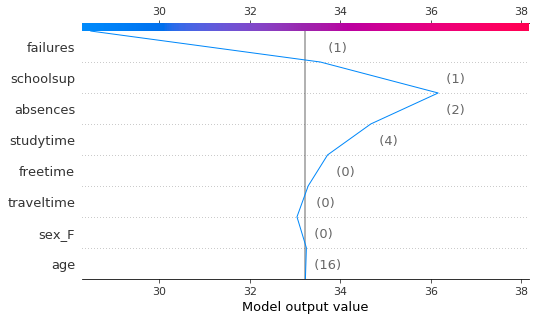

In [22]:
test_student = pd.DataFrame({"failures" : [1],
                             "absences" : [2],
                             "studytime" : [4],
                             "freetime" : [0],
                             "schoolsup" : [1],
                             "traveltime" : [0],
                             "age" : [16],
                             "sex_F" : [0]})

shap.initjs()

treeEx = shap.TreeExplainer(model_train)
shap_values_test = treeEx.shap_values(test_student)
shap.decision_plot(treeEx.expected_value, shap_values_test[0], test_student.iloc[[0]])

Here we witness the adverse affect of schoolsup = 1 on a student's grade. Behind failures, it is the second most powerful interaction occuring.

In [0]:
def get_sup_pred_diff(x, model):
    s1 = x.copy()
    s2 = x.copy()
    
    s1["schoolsup"] = 0
    s2["schoolsup"] = 1
    
    test_student = pd.concat([s1, s2], axis=1).T
    test_student = test_student[features]
    
    dataMatrix = xgboost.DMatrix(test_student)
    pred = model.predict(dataMatrix)
    return pred[1] - pred[0]

In [24]:
X_test['sup_pred_diff'] = X_test.apply(lambda row: get_sup_pred_diff(row, model_train), axis=1)
X_test["true grade"] = y_test


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


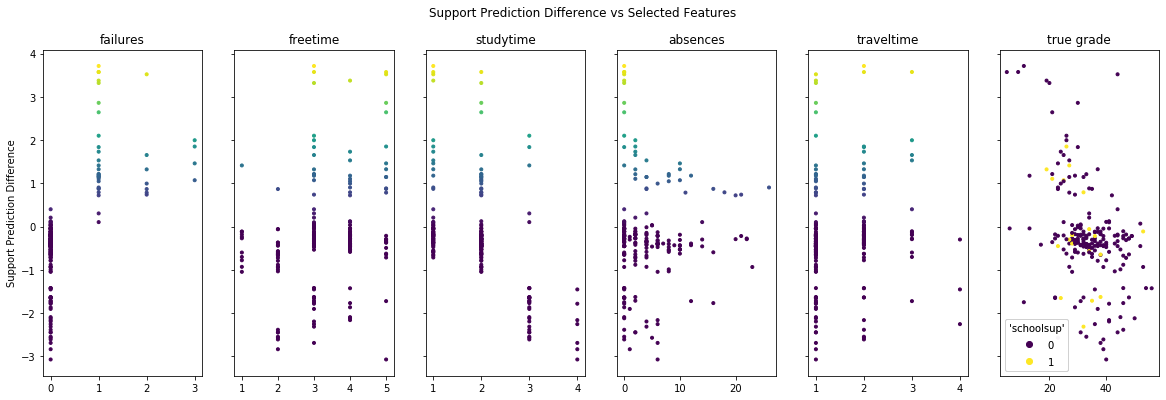

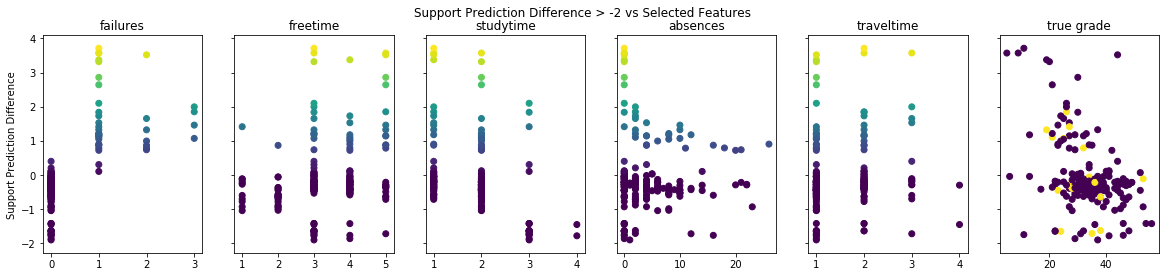

In [50]:
def bigplot(X_test, title):
  fig, (ax_1, ax_2, ax_3, ax_4, ax_5, ax_6) = plt.subplots(nrows=1, ncols=6, sharey=True, figsize=(20, 6))
  ax_1.set_title('failures')
  ax_1.scatter('failures', 'sup_pred_diff', data=X_test, c=np.maximum(X_test["sup_pred_diff"], 0), marker='.', cmap='viridis')
  ax_2.set_title('freetime')
  ax_2.scatter('freetime', 'sup_pred_diff', data=X_test, c=np.maximum(X_test["sup_pred_diff"], 0), marker='.', cmap='viridis')
  ax_3.set_title('studytime')
  ax_3.scatter('studytime', 'sup_pred_diff', data=X_test, c=np.maximum(X_test["sup_pred_diff"], 0), marker='.', cmap='viridis')
  ax_4.set_title('absences')
  ax_4.scatter('absences', 'sup_pred_diff', data=X_test, c=np.maximum(X_test["sup_pred_diff"], 0), marker='.', cmap='viridis')
  ax_5.set_title('traveltime')
  ax_5.scatter('traveltime', 'sup_pred_diff', data=X_test, c=np.maximum(X_test["sup_pred_diff"], 0), marker='.', cmap='viridis')
  ax_6.set_title('true grade')
  a = ax_6.scatter('true grade', 'sup_pred_diff', data=X_test, c=X_test["schoolsup"], marker='.', cmap='viridis')
  legend = ax_6.legend(*a.legend_elements(),
                    loc="lower left", title="'schoolsup'")
  ax_6.add_artist(legend)
  ax_1.set_ylabel('Support Prediction Difference')
  fig.suptitle(title % '')
  plt.show()

  fig, (ax_1, ax_2, ax_3, ax_4, ax_5, ax_6) = plt.subplots(nrows=1, ncols=6, sharey=True, figsize=(20, 4))
  ax_1.set_title('failures')
  ax_1.scatter('failures', 'sup_pred_diff', data=X_test.where(X_test.sup_pred_diff > -2), c=np.maximum(X_test["sup_pred_diff"], 0), cmap='viridis')
  ax_2.set_title('freetime')
  ax_2.scatter('freetime', 'sup_pred_diff', data=X_test.where(X_test.sup_pred_diff > -2), c=np.maximum(X_test["sup_pred_diff"], 0), cmap='viridis')
  ax_3.set_title('studytime')
  ax_3.scatter('studytime', 'sup_pred_diff', data=X_test.where(X_test.sup_pred_diff > -2), c=np.maximum(X_test["sup_pred_diff"], 0), cmap='viridis')
  ax_4.set_title('absences')
  ax_4.scatter('absences', 'sup_pred_diff', data=X_test.where(X_test.sup_pred_diff > -2), c=np.maximum(X_test["sup_pred_diff"], 0), cmap='viridis')
  ax_5.set_title('traveltime')
  ax_5.scatter('traveltime', 'sup_pred_diff', data=X_test.where(X_test.sup_pred_diff > -2), c=np.maximum(X_test["sup_pred_diff"], 0), cmap='viridis')
  ax_6.set_title('true grade')
  ax_6.scatter('true grade', 'sup_pred_diff', data=X_test.where(X_test.sup_pred_diff > -2), c=X_test["schoolsup"], cmap='viridis')
  ax_1.set_ylabel('Support Prediction Difference')
  fig.suptitle(title % "> -2 ")
  plt.show()

bigplot(X_test, "Support Prediction Difference %svs Selected Features")

These plots show that for the majority of students our model predicts that extra support will not help them. The purple dots indicate a student that is predicted to perform better with support. The few cases that are helped are students with freetime but low study time and absences. 

The model in its current state would not be that helpful for selecting between individual cases, but there is a clear seperation between two cohorts (around -2 support prediction difference). The students who actually received support are coloured **yellow** in the 'true grade' charts. 

## **Experiment 2 part 2**: Fixing(?) the bias
Below I attempt to 'fix' this bias by preprocessing the dataset.
### Attempt 1: **Adjusting the Means**


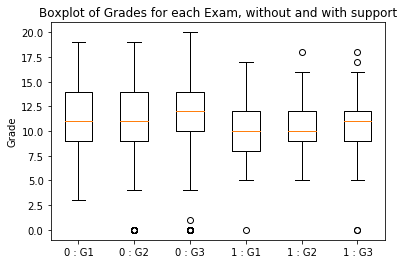

In [40]:
bias_test = tidy_data.copy(deep=True)

yes_sup = bias_test.loc[bias_test['schoolsup'] == 1]
no_sup = bias_test.loc[bias_test['schoolsup'] == 0]

data = [no_sup["G1"], no_sup["G2"], no_sup["G3"], yes_sup["G1"], yes_sup["G2"], yes_sup["G3"]]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.boxplot(data)
ax.set_ylabel("Grade")
ax.set_xticklabels(["0 : G1", "0 : G2", "0 : G3", "1 : G1", "1 : G2", "1 : G3"])
ax.set_title("Boxplot of Grades for each Exam, without and with support")
fig.show()

This boxplot shows us the difference between the two groups, unsupported and supported. In order to account for the differences in these groups I balance the means for each exam.  
`supported student's grade += mean of unsupported grades - mean of supported grades`

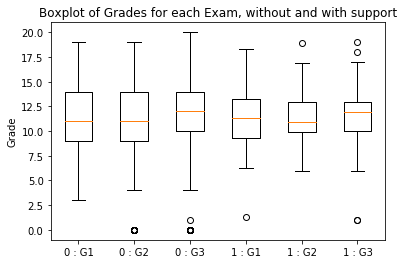

In [41]:
ng1 = np.mean(no_sup["G1"])
ng2 = np.mean(no_sup["G2"])
ng3 = np.mean(no_sup["G3"])

bias_test.loc[tidy_data['schoolsup'] == 1, "G1"] += ng1 - np.mean(yes_sup["G1"])
bias_test.loc[tidy_data['schoolsup'] == 1, "G2"] += ng2 - np.mean(yes_sup["G2"])
bias_test.loc[tidy_data['schoolsup'] == 1, "G3"] += ng3 - np.mean(yes_sup["G3"])

yes_sup = bias_test.loc[bias_test['schoolsup'] == 1]

data = [no_sup["G1"], no_sup["G2"], no_sup["G3"], yes_sup["G1"], yes_sup["G2"], yes_sup["G3"]]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.boxplot(data)
ax.set_ylabel("Grade")
ax.set_xticklabels(["0 : G1", "0 : G2", "0 : G3", "1 : G1", "1 : G2", "1 : G3"])
ax.set_title("Boxplot of Grades for each Exam, without and with support")
fig.show()

In [0]:
bias_test["grade"] = bias_test["G1"] + bias_test["G2"] + bias_test["G3"]

In [43]:
#Build the xgboost matrices
train, test = train_test_split(bias_test, test_size=0.2, random_state=1)
features = ['failures', 'absences', 'studytime', 'freetime', 'schoolsup', 'traveltime', 'age', 'sex_F']

X_train = train[features]
y_train = train['grade']

X_test = test[features]
y_test = test['grade']

X_total = tidy_data[features]

xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

Series.base is deprecated and will be removed in a future version
Series.base is deprecated and will be removed in a future version


[0]	test-mae:33.3186
[100]	test-mae:27.2888
[200]	test-mae:22.431
[300]	test-mae:18.5251
[400]	test-mae:15.4088
[500]	test-mae:12.9485
[600]	test-mae:11.015
[700]	test-mae:9.5276
[800]	test-mae:8.41621
[900]	test-mae:7.64533
[1000]	test-mae:7.11979
[1100]	test-mae:6.78652
[1200]	test-mae:6.57776
[1300]	test-mae:6.42234
[1400]	test-mae:6.31428
[1500]	test-mae:6.24058
[1599]	test-mae:6.19239


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


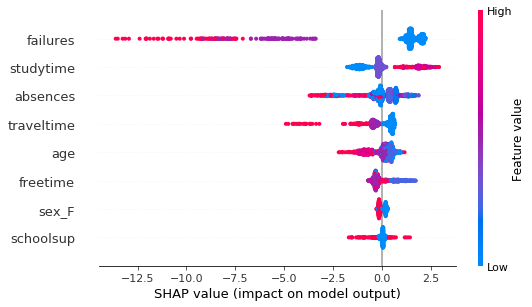

In [44]:
model_train = xgboost.train(params, xgb_train, 1600, evals = [(xgb_test, "test")], verbose_eval=100)
shap_values = shap.TreeExplainer(model_train).shap_values(X_total)
shap.summary_plot(shap_values, X_total)

This summary chart is showing us that we have neutered 'schoolsup's predictive quality - it now has the **least impact** on the output prediction of all the features.


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


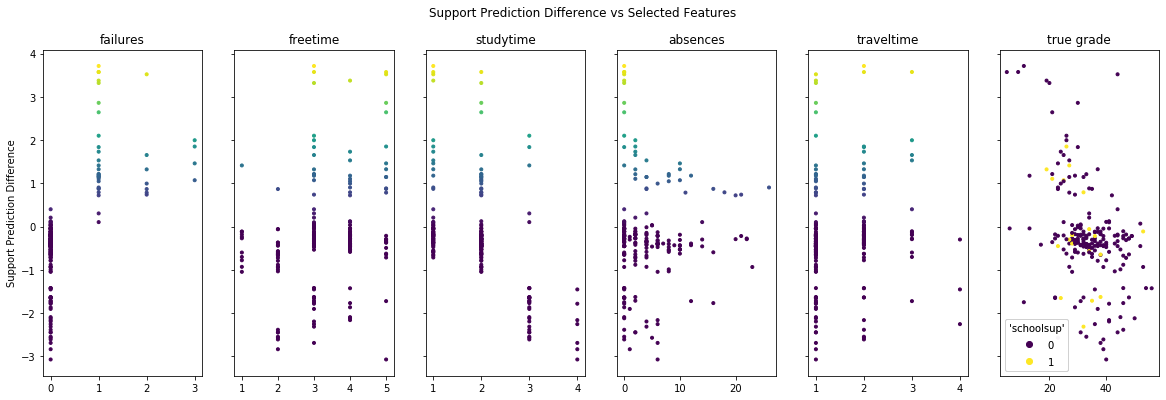

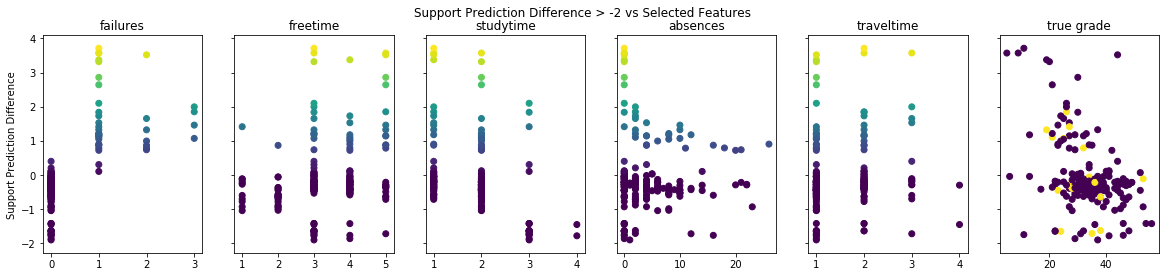

In [51]:
X_test['sup_pred_diff'] = X_test.apply(lambda row: get_sup_pred_diff(row, model_train), axis=1)
X_test["true grade"] = tidy_data["grade"]
bigplot(X_test, "Support Prediction Difference %svs Selected Features")

In [55]:
X_test.sort_values("sup_pred_diff", ascending=False).head()

,failures,absences,studytime,freetime,schoolsup,traveltime,age,sex_F,sup_pred_diff,true grade
383,1,0,1,3,0,2,19,0,3.713621,11
992,1,0,2,3,0,3,18,1,3.574257,9
1000,1,0,1,5,0,2,19,1,3.572746,5
746,2,0,1,5,0,1,20,0,3.520645,44
827,1,0,1,4,0,1,17,1,3.375492,19


In [54]:
X_test[X_test["schoolsup"] == 1].sort_values("sup_pred_diff", ascending=False).head()

,failures,absences,studytime,freetime,schoolsup,traveltime,age,sex_F,sup_pred_diff,true grade
78,3,2,1,5,1,2,17,0,1.850594,26
111,1,0,3,1,1,1,16,1,1.412962,27
72,2,2,2,3,1,1,15,1,1.322001,19
49,1,2,2,4,1,1,15,1,1.103853,21
2,3,10,2,3,1,1,15,1,1.070786,25


This approach had some benefit! It stopped our model from discriminating based on 'schoolsup' as we attempted to level the playing field between the two groups. Unfortunately for our purposes (working out who needs support) this does not seem to have helped.

### Attempt 2: **Making some Noise**

The second preprocessing technique I tried was to introduce noise by 'flipping' a certain number of students who don't receive support 'schoolsup' == 0, to 'schoolsup' == 1 before we train the model.

True 0 : 1 schoolsup ratio
925 : 119
Noised 0 : 1 schoolsup ratio
648 : 396
[0]	test-mae:33.0319
[100]	test-mae:27.0686


Series.base is deprecated and will be removed in a future version
Series.base is deprecated and will be removed in a future version


[200]	test-mae:22.2582
[300]	test-mae:18.3891
[400]	test-mae:15.2977
[500]	test-mae:12.8492
[600]	test-mae:10.9737
[700]	test-mae:9.51596
[800]	test-mae:8.43205
[900]	test-mae:7.65108
[1000]	test-mae:7.13167
[1100]	test-mae:6.80976
[1200]	test-mae:6.61343
[1300]	test-mae:6.46217
[1400]	test-mae:6.35428
[1500]	test-mae:6.28138
[1599]	test-mae:6.23305


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


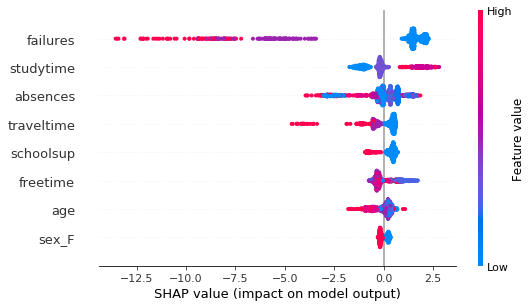


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


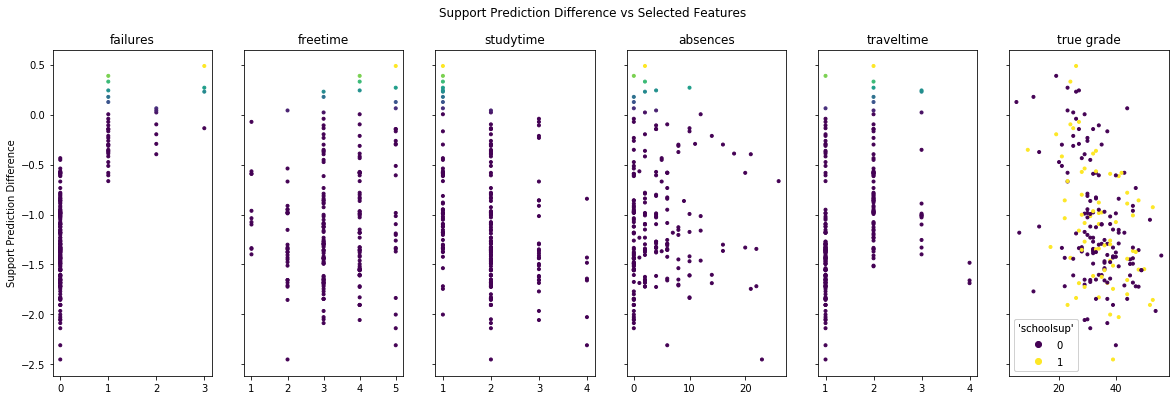

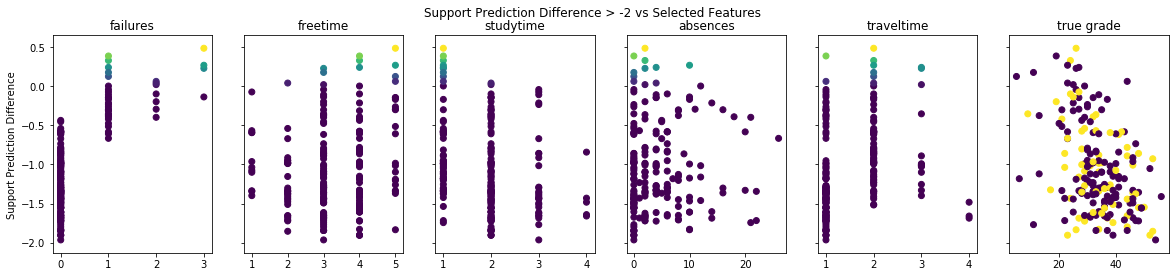

In [60]:
bias_noise_test = tidy_data.copy(deep=True)
#### try changing the noise ratio here:
# 0: no change, 0.4 approximately balanced, 1: all 1
noise_ratio = 0.3

print("True 0 : 1 schoolsup ratio")
print(len(bias_noise_test.loc[bias_noise_test['schoolsup'] == 0]), ":", len(bias_noise_test.loc[bias_noise_test['schoolsup'] == 1]))

def noisify(arr, ratio):
  noise_arr = np.random.choice([1, 0], size=(len(arr),), p=[ratio, 1-ratio])
  return np.bitwise_or(arr, noise_arr)

schoolsup = bias_noise_test["schoolsup"].to_numpy()
bias_noise_test["schoolsup"] = noisify(schoolsup, noise_ratio)

print("Noised 0 : 1 schoolsup ratio")
print(len(bias_noise_test.loc[bias_noise_test['schoolsup'] == 0]), ":", len(bias_noise_test.loc[bias_noise_test['schoolsup'] == 1]))

train, test = train_test_split(bias_noise_test, test_size=0.2, random_state=1)
features = ['failures', 'absences', 'studytime', 'freetime', 'schoolsup', 'traveltime', 'age', 'sex_F']
X_train = train[features]
y_train = train['grade']
X_test = test[features]
y_test = test['grade']
X_total = tidy_data[features]
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)
model_train = xgboost.train(params, xgb_train, 1600, evals = [(xgb_test, "test")], verbose_eval=100)
shap_values = shap.TreeExplainer(model_train).shap_values(X_total)
shap.summary_plot(shap_values, X_total)

X_test['sup_pred_diff'] = X_test.apply(lambda row: get_sup_pred_diff(row, model_train), axis=1)
X_test["true grade"] = tidy_data["grade"]
bigplot(X_test, "Support Prediction Difference %svs Selected Features")

Once again this technique is useful for reducing the interaction 'schoolsup' has with our output value, while maintaining _some_ of its predictive quality. But the same problem arises with the mean balancing: because we are directly affecting the feature we want to gain insight from, we are likely damaging our insight!

## **Experiment 3**: Predicting on 'alcohol score'
Like our total grade feature we build a new feature 'alcohol score' from existing features 'Walc' and 'Dalc'. These represent workday alcohol consumption and weekend alcohol consumption respectively. These features are a self reported score from 1 - very low to 5 - very high.

In [62]:
all_data = pd.merge(math_data, port_data, how='outer')
tidy_data = all_data.replace(['yes', 'no'], [1, 0])
tidy_data = pd.get_dummies(tidy_data)
tidy_data['alcohol score'] = tidy_data['Walc'] + tidy_data['Dalc']
tidy_data.head()

,age,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,alcohol score
0,18,4,4,2,2,0,1,0,0,0,1,1,0,0,4,3,4,1,1,3,6,5,6,6,1,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,2
1,17,1,1,1,2,0,0,1,0,0,0,1,1,0,5,3,3,1,1,3,4,5,5,6,1,0,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,2
2,15,1,1,1,2,3,1,0,1,0,1,1,1,0,4,3,2,2,3,3,10,7,8,10,1,0,1,0,0,1,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,5
3,15,4,2,1,3,0,0,1,1,1,1,1,1,1,3,2,2,1,1,5,2,15,14,15,1,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,2
4,16,3,3,1,2,0,0,1,1,0,1,1,0,0,4,3,2,1,2,5,4,6,10,10,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,3


In [63]:
#Build the xgboost matrices
train, test = train_test_split(tidy_data, test_size=0.2, random_state=1)

X_train = train.drop(labels=['alcohol score', 'Walc', 'Dalc'], axis=1)
y_train = train['alcohol score']

X_test = test.drop(labels=['alcohol score', 'Walc', 'Dalc'], axis=1)
y_test = test['alcohol score']

X_total = tidy_data.drop(labels=['alcohol score', 'Walc', 'Dalc'], axis=1)

xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

Series.base is deprecated and will be removed in a future version
Series.base is deprecated and will be removed in a future version


In [64]:
model_3 = xgboost.train(params, xgb_train, 1000, evals = [(xgb_test, "test")], verbose_eval=100)

[0]	test-mae:3.33036
[100]	test-mae:2.73217
[200]	test-mae:2.24927
[300]	test-mae:1.89296
[400]	test-mae:1.64399
[500]	test-mae:1.51593
[600]	test-mae:1.44607
[700]	test-mae:1.39163
[800]	test-mae:1.35108
[900]	test-mae:1.32812
[999]	test-mae:1.31342


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


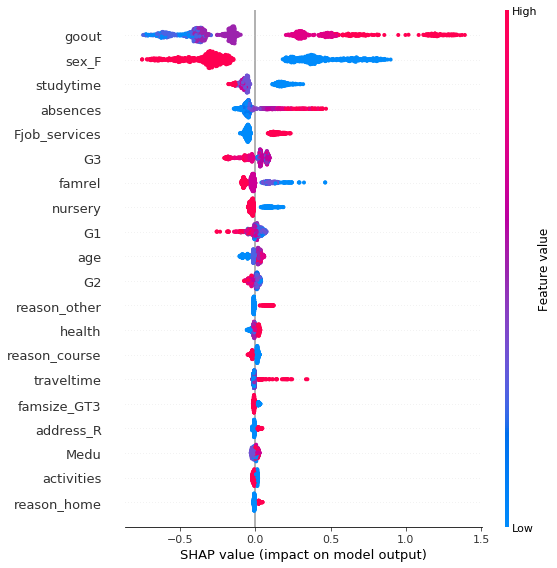

In [65]:
shap_values = shap.TreeExplainer(model_3).shap_values(X_total)
shap.summary_plot(shap_values, X_total)

Here, as before we see some intuitive relationships. A high value for 'goout' (1 - 5 how often does the student go out with friends) gives a positive SHAP value. 

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


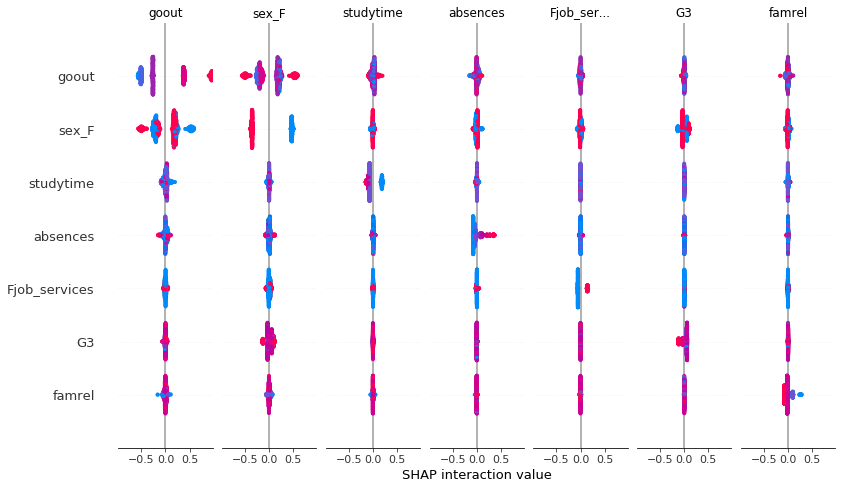

In [66]:
shap_interaction_values = shap.TreeExplainer(model_3).shap_interaction_values(X_total)
shap.summary_plot(shap_interaction_values, X_total)

This is a SHAP Interaction Value Summary Plot, it shows us potential interactions between our features. Along the diagonal we see the same summaries as above, but off the diagonal we see interactions between our features. This allows to - at a glance - work out what we should investigate further. From this I want to look further into goout x sex_F, goout x studytime and sex_F x G3.

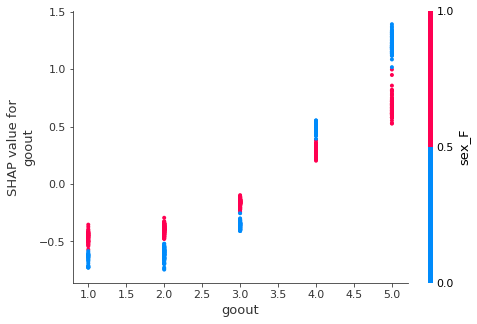

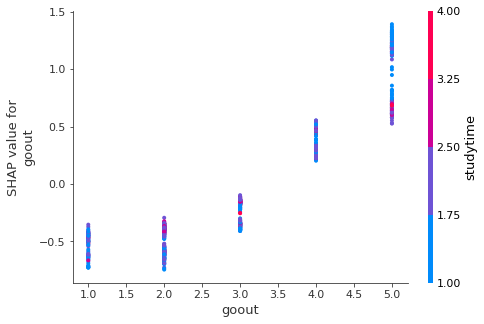

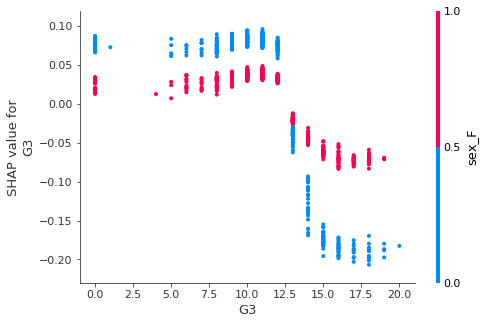

In [69]:
shap.dependence_plot('goout', shap_values, X_total)
shap.dependence_plot('goout', shap_values, X_total, interaction_index="studytime")
shap.dependence_plot('G3', shap_values, X_total, interaction_index="sex_F")

Clearly TreeExplainer is a powerful tool for assessing relationships and interactions within a dataset. I'm not entirely convinced that it should be added to every Data Scientist's toolbelt - but it gives local (& to some degree global) interpretability that is invaluable in an iterative, model focused workflow. I would be interested to see how much the values/relationships change using a different model architecture, as I may have stumbled on some limitations or artifacts unique to Tree-based models that I am unaware of.